In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from mtree import MTree
import pickle
from collections import namedtuple

In [13]:
def image2array(nome_arquivo, startHeight = 0, startWidth = 0, endHeight = None, endWidth = None):
    """
    Converte uma imagem em um array NumPy normalizado (float32).

    Parameters
    ----------
    nome_arquivo : str
        O caminho para o arquivo de imagem.
    startHeight : int, optional
        A altura inicial para começar a leitura dos pixels (default é 0).
    startWidth : int, optional
        A largura inicial para começar a leitura dos pixels (default é 0).

    Returns
    -------
    np.ndarray
        Um array NumPy de forma (altura-startHeight, largura-startWidth, 3) contendo os valores normalizados (float32) dos pixels da imagem.
    """
    imagem = Image.open(nome_arquivo)
    largura, altura = imagem.size
    if endHeight is None:
        endHeight = altura
    if endWidth is None:
        endWidth = largura
    matriz_pixels = np.zeros((endHeight-startHeight, endWidth-startWidth, 3), dtype=np.float32)
    for y in range(startHeight, endHeight):
        for x in range(startWidth, endWidth):
            r, g, b = imagem.getpixel((x, y))
            matriz_pixels[y-startHeight, x-startWidth] = [r/255, g/255, b/255]
    return matriz_pixels

def array2image(matriz_pixels):
    """
    Converte um array NumPy em uma imagem e mostra a image.

    Parameters
    ----------
    array : np.ndarray
        Um array NumPy de forma (altura, largura, 3) contendo os valores dos pixels da imagem. Os valores devem estar no intervalo [0, 1].

    Returns
    -------
    None
    """
    altura, largura, _ = matriz_pixels.shape
    imagem = Image.new('RGB', (largura, altura))
    for y in range(altura):
        for x in range(largura):
            r, g, b = matriz_pixels[y, x]
            imagem.putpixel((x, y), (int(r*255), int(g*255), int(b*255)))
    # Display image using matplotlib
    imagem.show()

def flatIdx2pos(idx, width):
    return (idx//width, idx%width)

def pos2flatIdx(pos, width):
    return pos[0]*width + pos[1]

In [14]:
# Carrega imagem recortada
fullW, fullH = (2722, 2009)

x, y = (2300, 1250)

sH = y - 100
eH = y + 100
sW = x - 100
eW = x + 100

imarr = image2array('../datasets/vangogh.jpg', startHeight=sH, startWidth=sW, endWidth=eW, endHeight=eH)

In [16]:
# Transforma matriz bidimensional para array com pixels
altura, largura = imarr.shape[0], imarr.shape[1]
W = largura
total_pixels = altura * largura

imarr_flat = imarr.reshape(total_pixels, 3)
print(f"{altura} x {largura} = {total_pixels} pixels")
np.save(f'../datasets/vangogh{altura}x{largura}.npy', imarr_flat)

200 x 200 = 40000 pixels


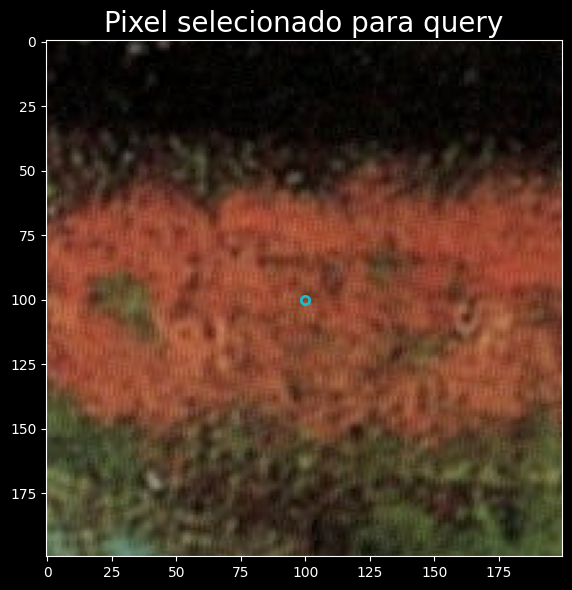

In [17]:
# Plota imagem e ponto usado para query
plt.figure(figsize=(6, 6))
plt.imshow(imarr)
x = largura//2
y = altura//2
plt.plot(x, y, 'o', color='tab:cyan', mfc='none', mew=2)
plt.title('Pixel selecionado para query', fontsize=20)
plt.tight_layout()

## 1.1) Criar árvore

In [18]:
count = 0
# Create named tuple with ID and data
Point = namedtuple('Point', ['id', 'data'])

def d(a: Point, b: Point):
    global count
    count += 1
    return np.linalg.norm(a.data - b.data)

tree = MTree(d, max_node_size=100)
percent = 0
times = []
if os.path.exists(f'../datasets/mtree_vangogh{altura}x{largura}.pkl'):
    print("Já criada.")
else:
    for i in range(total_pixels):
        t0 = time.time()
        tree.add(Point(i, imarr_flat[i]))
        t1 = time.time()
        times.append(t1 - t0)
        if i/total_pixels > percent:
            print(f"{percent*100:.0f}%")
            print(f"Tempo total: {np.sum(times):.2f}s, média: {np.mean(times)*1000:.2f} ms")
            times = []
            percent += 0.05
    
    with open(f'../datasets/mtree_vangogh{altura}x{largura}.pkl', 'wb') as output:
        pickle.dump(tree, output)

Já criada.


In [19]:
count

0

In [20]:
def L2(query, features):
    # Compute L2 distance between query and features
    return np.sqrt(np.sum((query - features)**2, axis=1))

def knn_sequential(query, k, features, distFunc = None, tie = 0):
    if distFunc is None:
        distFunc = L2
    
    # Vetor com distâncias
    distances = distFunc(query, features)
    k_nearest = []
     
    for i in range(k):
        min_idx = np.argmin(distances)
        k_nearest.append((min_idx, distances[min_idx]))
        distances[min_idx] = np.inf
        
    # Check if there are more features with the same distance
    if tie:
        min_idx = np.argmin(distances)
        while distances[min_idx] == k_nearest[-1][1]:
            k_nearest.append((min_idx, distances[min_idx]))
            distances[min_idx] = np.inf
            min_idx = np.argmin(distances)
    
    return k_nearest

def knn_tree(query, k, tree):
    return tree.search(query, k=k)

## 1.2) Busca sequencial

In [21]:
query = imarr_flat[pos2flatIdx((y, x), W)]
features = np.load(f'../datasets/vangogh{altura}x{largura}.npy')
print("Features.shape:", features.shape)
k = 32
times = []
for _ in range(200):
    t0 = time.time()
    k_nearest = knn_sequential(query, k, features, tie=0)
    t1 = time.time()
    times.append(t1 - t0)
print(f"Median time: {np.median(times)*1000:.3f} ms")
print(k_nearest)

Features.shape: (40000, 3)
Median time: 2.998 ms
[(15402, 0.0), (19724, 0.0), (20100, 0.0), (20107, 0.0), (21338, 0.0), (22098, 0.0), (24557, 0.0), (26063, 0.0), (26269, 0.0), (13708, 0.005545935), (13720, 0.005545935), (17518, 0.005545935), (18034, 0.005545935), (19097, 0.005545935), (20475, 0.005545935), (21906, 0.005545935), (22524, 0.005545935), (23291, 0.005545935), (24797, 0.005545935), (25189, 0.005545935), (25664, 0.005545935), (26081, 0.005545935), (12272, 0.006792356), (13722, 0.006792356), (16696, 0.006792356), (16700, 0.006792356), (16701, 0.006792356), (17502, 0.006792356), (19098, 0.006792356), (19297, 0.006792356), (19728, 0.006792356), (19931, 0.006792356)]


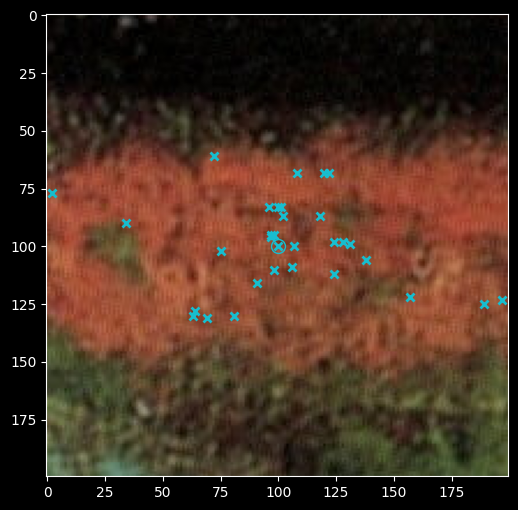

In [22]:
# Plot result in matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(imarr)
plt.plot(x, y, 'o', color='tab:cyan', mfc='none', mew=1, ms=10)
for i in range(len(k_nearest)):
    pos = flatIdx2pos(k_nearest[i][0], W)
    plt.plot(pos[1], pos[0], 'x', color='tab:cyan', mfc='none', mew=2)

## 1.3) Busca MTree

In [23]:
query = imarr_flat[pos2flatIdx((y, x), W)]
with open(f'../datasets/mtree_vangogh{altura}x{largura}.pkl', 'rb') as f:
    tree = pickle.load(f)

count = 0
k = 32
times = []
for _ in range(1):
    t0 = time.time()
    k_nearest = knn_tree(query, k, tree)
    t1 = time.time()
    print(f"Count: {count}")
    print(f"Time: {(t1 - t0)*1000:.3f}ms")
    times.append(t1 - t0)
    count = 0
    lknn = list(k_nearest)

Count: 6044
Time: 177.168ms


In [24]:
for p in lknn:
    print(p.id, end=", ")

21338, 20107, 20100, 19724, 26269, 22098, 24557, 26063, 15402, 23291, 21906, 19097, 25189, 24797, 22524, 20475, 26081, 25664, 17518, 18034, 13720, 13708, 24881, 20106, 21400, 26263, 23091, 21873, 22090, 28543, 22099, 